In [2]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import seaborn as sns
import keras 
import datetime
import requests
import warnings
import keras

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima

import prophet

warnings.filterwarnings('ignore')

/Users/ChloeSokol/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Pre-processing

In [21]:
df = pd.read_csv('multivar.csv')
df = df.drop(columns=['iso_code'])
df = df.drop(columns=['location'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
categorical_cols = ['continent', 'tests_units', 'season']
df = pd.get_dummies(df, columns=categorical_cols)
df

,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,new_vaccinations,...,continent_Asia,continent_Europe,continent_North America,continent_South America,tests_units_people tested,tests_units_tests performed,season_Autumn,season_Spring,season_Summer,season_Winter
date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,1.0,0.0,0.0,0.086,0.000,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,1,0,1,0,0
2020-03-08,316.0,315.0,0.0,27.111,27.025,0.000,0.000,NaN,NaN,NaN,...,0,1,0,0,0,1,0,1,0,0
2020-03-15,1362.0,1046.0,9.0,116.850,89.740,4.547,22.564,NaN,18.960,NaN,...,0,1,0,0,0,1,0,1,0,0
2020-03-22,4473.0,3111.0,140.0,383.753,266.903,27.969,142.503,NaN,128.604,NaN,...,0,1,0,0,0,1,0,1,0,0
2020-03-29,12031.0,7558.0,602.0,1032.179,648.426,82.447,389.158,NaN,300.191,NaN,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-10,103436829.0,NaN,1614.0,305763.910,NaN,7.168,58.512,NaN,70.395,NaN,...,0,0,1,0,0,0,0,0,0,1
2023-12-17,103436829.0,NaN,1450.0,305763.910,NaN,7.325,62.390,NaN,75.678,NaN,...,0,0,1,0,0,0,0,0,0,1
2023-12-24,103436829.0,NaN,1263.0,305763.910,NaN,8.546,68.988,NaN,89.101,NaN,...,0,0,1,0,0,0,0,0,0,1


In [22]:
def process(df):
    lag1df = df.shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df=df[['new_deaths']].join(lag1df)
    return df.fillna(0) 
def normalize(df):
    for col in df.columns:
        if col != 'new_deaths':
            df[col]=(df[col]-df[col].mean())/df[col].std()
    return df 

In [23]:
df=process(df)
df=normalize(df)
df.shape

(20209, 58)

In [27]:
def make_series(data):
    series=[]
    for i in range(len(data)-14):
        subdf=data[i:i+14]
        series.append( (subdf.index[-1], subdf['new_deaths'].values[-1], subdf.drop('new_deaths', axis=1).values))
    return series
series=make_series(df)
print(series[0][0],series[0][1].shape,series[0][2].shape)
train_size = int(len(series) * 0.7)
train, test = series[0:train_size], series[train_size:]
#train=series[:-30]
#test=series[-30:]

2020-03-01 00:00:00 () (14, 57)


# Attempt 1

## Training

In [30]:
learning_rate = 0.01
batch_size = 32
epochs = 100
sequence_length =14

In [31]:
inputs = keras.layers.Input(shape=(14,57))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14, 57)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                11520     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,553
Trainable params: 11,553
Non-trainable params: 0
_________________________________________________________________


In [32]:
x=np.array([x[2].reshape(14,57) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

(14136, 14, 57)
(14136,)
Epoch 1/100
442/442 [==============================] - 10s 14ms/step - loss: 1099.9236
Epoch 2/100
442/442 [==============================] - 6s 13ms/step - loss: 1084.7145
Epoch 3/100
442/442 [==============================] - 6s 14ms/step - loss: 1078.4161
Epoch 4/100
442/442 [==============================] - 6s 14ms/step - loss: 1075.7275
Epoch 5/100
442/442 [==============================] - 7s 17ms/step - loss: 1074.1771
Epoch 6/100
442/442 [==============================] - 6s 14ms/step - loss: 1072.8005
Epoch 7/100
442/442 [==============================] - 6s 13ms/step - loss: 1071.8357
Epoch 8/100
442/442 [==============================] - 5s 12ms/step - loss: 1071.4094
Epoch 9/100
442/442 [==============================] - 6s 13ms/step - loss: 1070.8701
Epoch 10/100
442/442 [==============================] - 6s 13ms/step - loss: 1070.7620
Epoch 11/100
442/442 [==============================] - 5s 12ms/step - loss: 1070.3838
Epoch 12/100
442/442 [====

## Testing

In [33]:
train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train ])
train_pred.head()

442/442 [==============================] - 3s 5ms/step


,yhat
2020-03-01,0.272598
2020-03-01,0.117481
2020-03-01,0.070992
2020-03-01,0.397257
2020-03-01,2.710423


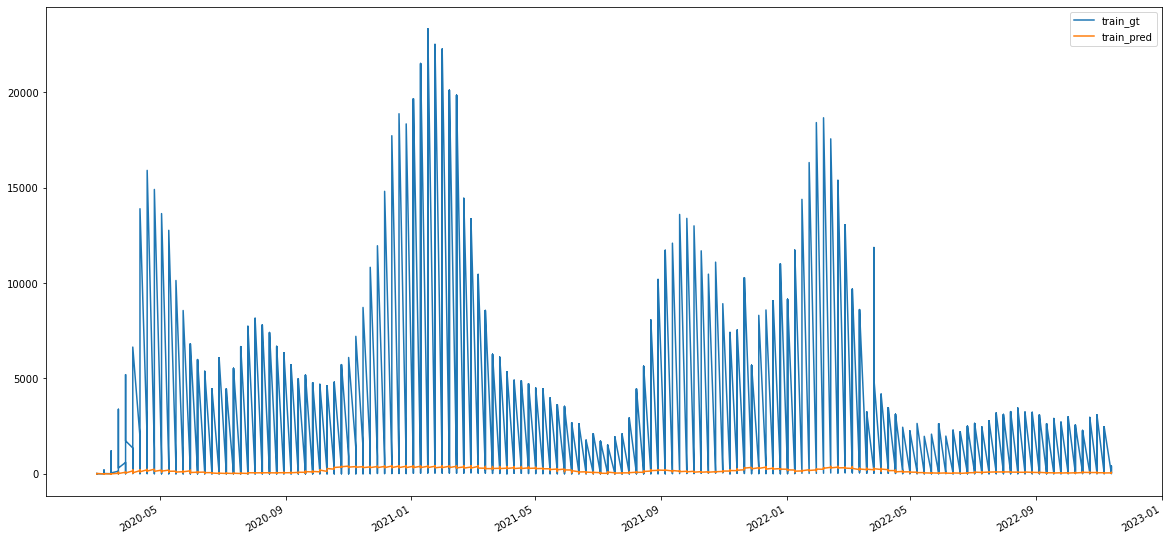

In [34]:
train_gt= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

190/190 [==============================] - 1s 4ms/step


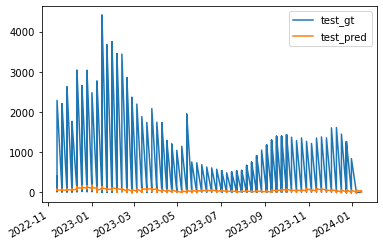

In [35]:
test_pred=model.predict(np.array([x[2].reshape(14, 57) for x in test]))
test_pred=pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt=pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])
pd.concat([test_gt, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

## Metrics

In [36]:
mae = mean_absolute_error(test_gt, test_pred)
mape = mean_absolute_percentage_error(test_gt, test_pred)
r2 = r2_score(test_gt, test_pred)
print('Test MAE: ', mae)
print('Test MAPE: ', mape)
print('Test r-squared: ', r2)

Test MAE:  215.78187722556956
Test MAPE:  2.181661267987616e+16
Test r-squared:  -0.08710305955672837


# Attempt 2

## Training

In [37]:
learning_rate = 0.001
batch_size = 16
epochs = 50
sequence_length =14

In [38]:
inputs = keras.layers.Input(shape=(14,57))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 14, 57)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                11520     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,553
Trainable params: 11,553
Non-trainable params: 0
_________________________________________________________________


In [39]:
x=np.array([x[2].reshape(14,57) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

(14136, 14, 57)
(14136,)
Epoch 1/50
884/884 [==============================] - 20s 17ms/step - loss: 1114.4894
Epoch 2/50
884/884 [==============================] - 15s 17ms/step - loss: 1102.3909
Epoch 3/50
884/884 [==============================] - 17s 19ms/step - loss: 1096.4557
Epoch 4/50
884/884 [==============================] - 16s 18ms/step - loss: 1092.4102
Epoch 5/50
884/884 [==============================] - 13s 14ms/step - loss: 1089.1295
Epoch 6/50
884/884 [==============================] - 11s 12ms/step - loss: 1086.4176
Epoch 7/50
884/884 [==============================] - 10s 12ms/step - loss: 1084.2784
Epoch 8/50
884/884 [==============================] - 10s 12ms/step - loss: 1082.2729
Epoch 9/50
884/884 [==============================] - 10s 11ms/step - loss: 1080.6127
Epoch 10/50
884/884 [==============================] - 11s 12ms/step - loss: 1079.1964
Epoch 11/50
884/884 [==============================] - 10s 12ms/step - loss: 1077.9589
Epoch 12/50
884/884 [======

## Testing

In [40]:
train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train ])

442/442 [==============================] - 3s 5ms/step


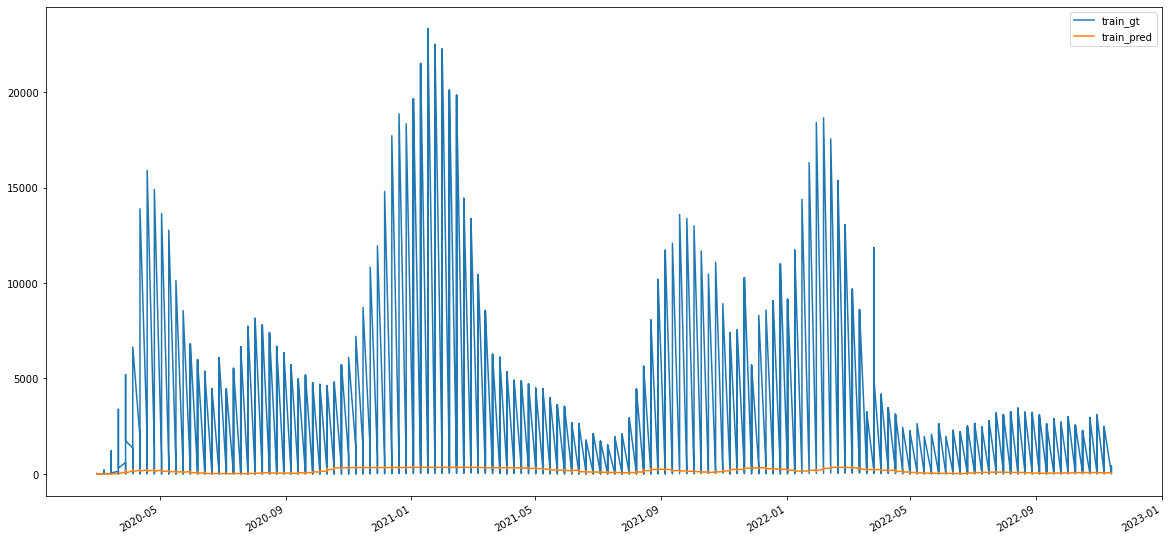

In [41]:
train_gt= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

190/190 [==============================] - 2s 8ms/step


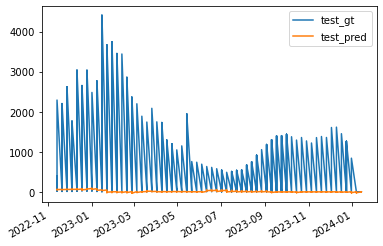

In [42]:
test_pred=model.predict(np.array([x[2].reshape(14, 57) for x in test]))
test_pred=pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt=pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])
pd.concat([test_gt, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

## Metrics

In [43]:
mae = mean_absolute_error(test_gt, test_pred)
mape = mean_absolute_percentage_error(test_gt, test_pred)
r2 = r2_score(test_gt, test_pred)
print('Test MAE: ', mae)
print('Test MAPE: ', mape)
print('Test r-squared: ', r2)

Test MAE:  217.10070080953102
Test MAPE:  5882255838176767.0
Test r-squared:  -0.12531971622792093
